References:

* [d'Aspremont, A. (2011). Identifying small mean-reverting portfolios. *Quantitative Finance*, 11(3), pp.351-364.](https://arxiv.org/pdf/0708.3048.pdf)
* [Cuturi, M. and d'Aspremont, A. (2015). Mean-reverting portfolios: Tradeoffs between sparsity and volatility. *arXiv preprint arXiv:1509.05954.*](https://arxiv.org/abs/1509.05954)

# Sparse Mean-reverting Portfolio Selection

## Introduction

Assets that exhibit significant mean-reversion are difficult to find in efficient markets. As a result, investors focus on creating long-short asset baskets to form a mean-reverting portfolio whose aggregate value shows mean-reversion. Classic solutions including cointegration or canonical correlation analysis can only construct dense mean-reverting portfolios, i.e. they include every asset in the investing universe. These portfolios have shown significant disadvantages in transaction costs, P&L interpretability, and capturing meaningful statistical arbitrage opportunities. On the other hand, sparse mean-reverting portfolios, which requires trading as few assets as possible, can mitigate these shortcomings.

This research notebook will showcase three approaches to constructing a sparse mean-reverting portfolio using **ArbitrageLab**:

1. Covariance selection and penalized regression techniques to narrow down the investing universe;
2. Greedy search to construct sparse mean-reverting portfolios;
3. Semidefinite programming (SDP) approach to construct sparse mean-reverting portfolios above a volatility threshold.

A few key concepts will be introduced first to provide a better understanding of the sparse mean-reverting portfolio selection problem and an explanation to why these three approaches are effective.

## Mean-reversion Strength Metrics and Proxies

### Ornstein-Uhlenbeck Process and Mean-reversion Speed

The straightforward solution is to assume the portfolio value follows an Ornstein-Uhlenbeck (OU) process and use the mean-reversion speed parameter $\lambda$ to measure the mean-reversion strength.

$$
\begin{gather*}
dP_t = \lambda (\bar{P} - P_t)dt + \sigma dZ_t \\
P_t = \mathbf{x}^T S_t \\
\lambda > 0
\end{gather*}
$$

where $P_t$ is the portfolio value at time $t$, $\bar{P}$ is the average portfolio value, $Z_t$ is a standard Brownian motion, $\mathbf{x}$ is the weight vector of each asset in the portfolio, and $S_t$ is the individual asset prices at time $t$. The objective is to maximize $\lambda$ by adjusting $\mathbf{x}$ under the constraints that $\lVert \mathbf{x} \rVert_2 = 1$ and $\lVert \mathbf{x} \rVert_0 = k$, where 

* $\lVert \mathbf{x} \rVert_0$ denotes the number of non-zero elements in $\mathbf{x}$; this constraint is also referred to as *cardinality constraint*;
* $k > 0$ is an integer which represents the number of assets that should be included in the portfolio.

If the OU mean-reversion speed $\lambda$ can be expressed as a function of the portfolio weight vector $\mathbf{x}$, maximizing $\lambda$ will give the optimal asset weightings $\mathbf{x}$ during the process. However, this is rather difficult. Instead, three other mean-reversion strength proxies are employed to solve the sparse mean-reverting portfolio selection problem:

1. Predictability based on Box-Tiao canonical decomposition.
2. Portmanteau statistic.
3. Crossing statistic.

Meanwhile, the OU mean-reversion speed $\lambda$ is only used to evaluate the sparse portfolios generated by ArbitrageLab.

### Predictability and Box-Tiao Canonical Decomposition

Assume that the asset prices $S_t$ follows a vector autoregressive process of order one - a VAR(1) process.

$$
S_t = S_{t-1} A + Z_t
$$


where $A$ is a $n \times n$ square matrix and $Z_t$ is a vector of i.i.d. Gaussian noise with $Z_t \sim N(0, \Sigma)$, independent of $S_{t-1}$.

Assume also that the portfolio value $P_t$ follows the recursion:

$$
P_t = \hat{P}_{t-1} + \varepsilon_t
$$

where $\hat{P}_{t-1}$ is a predictor of $x_t$ built upon all past portfolio values recorded up to $t-1$,
and $\varepsilon_t$ is a vector i.i.d. Gaussian noise, where $\varepsilon_t \sim N(0, \Sigma)$, independent
of all past portfolio values $P_0, P_1, \ldots, P_{t-1}$.

Substitute the portfolio value with the linear combination of the asset price, and use the VAR(1) model as the predictor $\hat{P}_{t-1}$:

$$
\mathbf{x}^T S_t = \mathbf{x}^T {S}_{t-1} A + \mathbf{x}^T \varepsilon_t
$$

Now calculate the variance for both sides of the equation. Since the variance would not change if the mean is shifted, it is safe to assume that the mean price of each asset is zero. The variance equation can be written as:

$$
\mathbf{x}^T \Gamma_0 \mathbf{x} = \mathbf{x}^T A^T \Gamma_0 A \mathbf{x} + \Sigma
$$

where $\Gamma_0$ are the covariance matrices of and $S_t$.

Define the predictability of the portfolio value process as:

$$
\nu = \frac{\mathbf{x}^T A^T \Gamma_0 A \mathbf{x}}{\mathbf{x}^T \Gamma_0 \mathbf{x}}
$$

Then the above equation can be written as:

$$
1 = \nu + \frac{\Sigma}{\mathbf{x}^T \Gamma_0 \mathbf{x}}
$$

The interpretation of $\nu$ is straightforward. When $\nu$ is small, the variance of the Gaussian noise $\Sigma$ dominates and the portfolio value process will look like noise and is more strongly mean-reverting. Otherwise, the variance of the predicted value $\mathbf{x}^T A^T \Gamma_0 A \mathbf{x}$ dominates and the portfolio value process can be accurately predicted on average. More importantly, the predictability $\nu$ is a function of the portfolio weights $\mathbf{x}$, and thus the optimal portfolio can be obtained during the optimization.

Without the cardinality constraint $\lVert \mathbf{x} \rVert_0 = k$, optimizing predictability can be summarized as a generalized eigenvalue problem:

$$
\det (\lambda \Gamma_0 - A^T \Gamma_0 A) = 0
$$

To find the portfolio weight that forms a portfolio with the most (or the least) predictability, just calculate the eigenvector that corresponds to the maximal (or minimal) eigenvalue of the matrix $\Gamma_0^{-1} A^T \Gamma_0 A$. This process is Box-Tiao canonical decomposition. An example of combining covariance selection and Box-Tiao canonical decomposition to form a sparse mean-reverting portfolio will be shown in the later part of this research notebook.

### Portmanteau Statistic

Portmanteau statistic of order $p$ (Ljung and Box, 1978) tests if a process is white noise.
By definition, the portmanteau statistic is 0 if a process is white noise. Therefore, maximizing mean-reversion strength
is equivalent to minimizing the portmanteau statistic.

The advantage of portmanteau statistic over the Box-Tiao predictability is that this statistic requires no modeling
assumptions. The disadvantage, on the other hand, is higher computational complexity. The estimate of portmanteau
statistic of order $p$ is given as follows:

$$
\hat{\phi}_p(y) = \frac{1}{p} \sum_{k=1}^p \Big( \frac{\mathbf{x}^T \gamma_k \mathbf{x}}{\mathbf{x}^T \gamma_0 \mathbf{x}} \Big)^2
$$

where $\gamma_k$ is the sample lag-$k$ autocovariance matrix, defined as:

$$
\begin{align*}
\gamma_k & \equiv \frac{1}{T-k-1} \sum_{t=1}^{T-k}\tilde{S}_t \tilde{S}_{t+k}^T \\
\tilde{S}_t & \equiv S_t - \frac{1}{T} \sum_{t=1}^T S_t
\end{align*}
$$

### Crossing Statistic

Kedem and Yakowitz (1994) define the crossing statistic of a univariate process $x_t$ as the expected number of
crosses around 0 per unit of time:

$$
\xi(x_t) = \mathbf{E} \Bigg[ \frac{\sum_{t=2}^T \unicode{x1D7D9}_{\{x_t x_{t-1} \leq 0 \}}}{T-1} \Bigg]
$$

For a stationary AR(1) process, the crossing statistic can be reformulated with the cosine formula:

$$
\xi(x_t) = \frac{\arccos (a)}{\pi}
$$

where $a$ is the first-order autocorrelation, or the AR(1) coefficient of the stationary AR(1) process, where $\lvert a \rvert < 1$. The function $y = \arccos (a)$ is monotonic decreasing with respect to $a$
when $\lvert a \rvert < 1$. Therefore, stronger mean-reversion strength implies a greater crossing statistic,
which in turn implies a smaller first-order autocorrelation. To extend this result to the multivariate case,
Cuturi (2015) proposed to minimize $\mathbf{x}^T \gamma_1 \mathbf{x}$ and ensure that all absolute higher-order
autocorrelations $\lvert \mathbf{x}^T \gamma_k \mathbf{x} \rvert, \, k > 1$ are small.

## Constructing the Sparse Mean-reverting Portfolio

This section will showcase how ArbitrageLab help construct the sparse mean-reverting portfolios with the three approaches mentioned previously. All examples uses daily price data of 45 international equity ETFs from Jan 1st, 2016 to Jan 27th, 2021.

### Covariance Selection via Graphical LASSO and Structured VAR(1) Estimate via Penalized Regression

The Box-Tiao canonical decomposition relies on estimates of both the covariance matrix $\Gamma_0$ and the VAR(1)
coefficient matrix $A$ of the asset prices. Using an $\ell_1$-penalty, as shown in d'Aspremont (2011),
is able to simultaneously obtain numerically stable estimates and isolate key idiosyncratic dependencies
in the asset prices. The penalized estimates of $\Gamma_0$ and $A$ provides different perspective on the
conditional dependencies and their graphical representations help cluster the assets into several smaller groups.

#### Covariance Selection

Covariance selection is a process where the maximum likelihood estimation of the covariance matrix $\Gamma_0$ is
penalized by setting a certain number of coefficients in the inverse covariance matrix $\Gamma_0^{-1}$ to zero.
Zeroes in $\Gamma_0^{-1}$ corresponds to conditionally independent assets in the model, and the penalized, or
sparse, estimate of $\Gamma_0^{-1}$ is both numerically robust and indicative of the underlying structure of the
asset price dynamics.

The sparse estimate of $\Gamma_0^{-1}$ is obtained by solving the following optimization problem:

$$
\max_X \log \det X - \mathbf{Tr} (\Sigma X) - \alpha \lVert X \rVert_1
$$
    

where $\Sigma = \gamma_0$ is the sample covariance matrix, $\alpha> 0$ is the $\ell_1$-regularization
parameter, and $\lVert X \rVert_1$ is the sum of the absolute value of all the matrix elements.

#### Structured VAR(1) Estimate via Penalized Regression

Recall that under a VAR(1) model assumption, the asset prices $S_t$ follow the following process:

$$
    S_t = S_{t-1} A + Z_t
$$

For most financial time series, the noise terms are correlated such that $Z_t \sim N(0, \Sigma)$, where the noise
covariance is $\Sigma$. In this case, the VAR(1) coefficient matrix $A$ has to be directly estimated from
the data. A structured (penalized), or sparse, estimate of $A$ can be obtained column-wise via a LASSO regression
by minimizing the following objective function:

$$
    \DeclareMathOperator*{\argmin}{arg\,min}
    a_i = \argmin_x \lVert S_{it} - S_{t-1}x \rVert^2 + \lambda \lVert x \rVert_1
$$

where $a_i$ is a column of the matrix $A$, and $S_{it}$ is the price of asset $i$.

The sparse estimate of $A$ can be also obtained by applying a more aggressive penalty under a multi-task LASSO
model. The objective function being minimized is:

$$
    \DeclareMathOperator*{\argmin}{arg\,min}
    \argmin_A \lVert S_{t} - S_{t-1}A \rVert^2 + \alpha \sum_i \sqrt{\sum_j a_{ij}^2}
$$

where $a_{ij}$ is the element of the matrix $A$.

The multi-task LASSO model will suppress the coefficients in an entire column to zero, but its estimate is less robust
than the column-wise LASSO regression in terms of numerical stability. 

#### Clustering

If the Gaussian noise in the VAR(1) model is uncorrelated:

$$
    S_t = S_{t-1} A + Z_t, \; Z_t \sim N(0, \sigma \mathbf{I}), \, \sigma > 0
$$

then Gilbert (1994) has shown that the graph of the inverse covariance matrix $\Gamma_0^{-1}$ and the graph of
$A^T A$ share the same structure, i.e. the graph of $\Gamma_0^{-1}$ and $A^T A$ are disconnected along
the same clusters of assets.

When the Gaussian noise $Z_t$ is correlated, however, the above relation is no longer valid, but it is still
possible to find common clusters between the graph of penalized estimate of $\Gamma_0^{-1}$ and penalized estimate
of $A^T A$. This will help find a much smaller investing universe for sparse mean-reverting portfolios. 

#### Example

In [12]:
# Importing libraries
import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from arbitragelab.cointegration_approach.sparse_mr_portfolio import SparseMeanReversionPortfolio

%matplotlib inline

In [3]:
# Load data
etf_df = pd.read_csv("Country_ETF.csv", parse_dates=["Dates"])
etf_df.set_index("Dates", inplace=True)
etf_df.fillna(method='ffill', inplace=True)
etf_df.columns = [x.split()[0] for x in etf_df.columns]

# Construct the sparse mean-reverting portfolio selection class
etf_sparse_portf = SparseMeanReversionPortfolio(etf_df)

In [4]:
# Check the data 
etf_sparse_portf.assets.head(5)

,KSA,EWM,EGPT,EFNL,EWG,ENZL,EWL,EZA,NGE,EDEN,...,EWT,EWZ,VNM,EWW,NORW,GXG,ECH,EWO,EWY,TUR
Dates,,,,,,,,,,,,,,,,,,,,,
2016-01-01,24.2199,30.96,38.2100,32.61,26.19,37.48,31.04,46.71,28.24,55.8501,...,25.54,20.68,14.79,49.83,9.69,29.84,31.92,15.65,49.67,36.36
2016-01-04,23.5300,29.96,37.1290,32.43,25.56,37.20,30.69,45.61,27.88,55.6000,...,24.76,19.94,14.97,49.07,9.77,29.32,31.57,15.47,48.51,35.32
2016-01-05,23.5300,30.20,37.5000,31.90,25.32,36.72,30.62,45.77,27.76,55.2142,...,24.68,20.22,15.00,48.92,9.41,29.56,31.80,15.46,48.72,35.16
2016-01-06,22.6600,29.52,37.1000,31.46,25.03,36.21,30.16,44.38,27.32,55.0200,...,24.12,19.92,14.67,47.92,9.15,28.64,31.55,15.26,47.75,34.96
2016-01-07,21.8900,29.40,35.7811,31.32,24.53,35.80,29.67,42.14,26.52,54.3400,...,23.56,19.18,14.34,46.05,8.90,28.04,30.45,15.04,46.99,34.99


In [7]:
# Calculate the penalized estimates
sparse_var_est = etf_sparse_portf.LASSO_VAR_fit(1.4, threshold=7, multi_task_lasso=True)
_, sparse_prec_est = etf_sparse_portf.covar_sparse_fit(0.89)

# Generate the clusters
multi_LASSO_cluster_graph = etf_sparse_portf.find_clusters(sparse_prec_est, sparse_var_est)
multi_LASSO_clusters = list(sorted(nx.connected_components(multi_LASSO_cluster_graph), key=len, reverse=True))

# Check the first two clusters
print("1st cluster: {}\nAsset count: {}".format(multi_LASSO_clusters[0], len(multi_LASSO_clusters[0])))
print("2nd cluster: {}\nAsset count: {}".format(multi_LASSO_clusters[1], len(multi_LASSO_clusters[1])))

1st cluster: {'ENZL', 'EWY', 'EWG', 'EWI', 'EWL', 'EWK', 'EWT', 'EWN', 'INDA', 'EWQ', 'EIRL', 'EDEN', 'EFNL', 'EWJ', 'GXC'}
Asset count: 15
2nd cluster: {'EZA', 'EWP', 'ECH', 'EWO', 'GXG', 'THD', 'EWU', 'EWS'}
Asset count: 8


<div class="alert alert-block alert-info">
<b>Tip:</b> Covariance selection determines the size of the clusters. When fitting the graphical LASSO model, apply a larger regularizer parameter to make the covariance matrix as sparse as possible such that smaller clusters are obtained. </div> 

<div class="alert alert-block alert-info">
<b>Tip:</b> Both graphical LASSO model and LASSO regression are sensitive to the scale of the data. Use standardized data for this step, otherwise the LASSO models will not be able to yield a reasonable, or even feasible, solution.</div> 

The second cluster looks quite sparse. Now perform a Box-Tiao canonical decomposition on this small cluster.

In [9]:
# Construct another class on the cluster obtained previously
small_etf_sparse_portf = SparseMeanReversionPortfolio(etf_df[multi_LASSO_clusters[1]])

# Check the data
small_etf_sparse_portf.assets.head(5)

,EZA,EWP,ECH,EWO,GXG,THD,EWU,EWS
Dates,,,,,,,,
2016-01-01,46.71,28.27,31.92,15.65,29.84,58.64,32.28,20.56
2016-01-04,45.61,27.89,31.57,15.47,29.32,57.71,31.76,20.10
2016-01-05,45.77,27.65,31.80,15.46,29.56,57.58,31.68,20.18
2016-01-06,44.38,27.13,31.55,15.26,28.64,56.97,31.10,19.78
2016-01-07,42.14,26.74,30.45,15.04,28.04,55.01,30.24,19.24


In [24]:
# Perform Box-Tiao canonical decomposition
bt_weights = small_etf_sparse_portf.box_tiao()

# Retrieve the portfolio weights that corresponds to the smallest eigenvalue
sparse_portf_weight1 = bt_weights[:, -1]

# Check weights and pretty print the results
sparse_portf_weight_df = pd.DataFrame(sparse_portf_weight1.reshape(-1, 1))
sparse_portf_weight_df.columns = ['Weight']
sparse_portf_weight_df.index = small_etf_sparse_portf.assets.columns

sparse_portf_weight_df

C:\Anaconda3\envs\arbitragelab_test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


,Weight
EZA,0.105541
EWP,0.152039
ECH,-0.104442
EWO,-0.145805
GXG,-0.259847
THD,0.109448
EWU,0.640490
EWS,-0.666222


Retrieve the portfolio weights that yield the least predictability, i.e. strongest mean-reversion. Check the OU mean-reversion coefficient and half-life and plot the portfolio value in Figure 1.

In [36]:
# Form the portfolio
sparse_portf1 = small_etf_sparse_portf.assets @ sparse_portf_weight1

# Fit an OU-model to see the mean-reversion speed parameter and half-life
coeff, hl = small_etf_sparse_portf.mean_rev_coeff(sparse_portf_weight1, small_etf_sparse_portf.assets)
print("Mean-rev Coefficient: {}; half-life: {}".format(coeff, hl))

Mean-rev Coefficient: 19.804853848370147; half-life: 8.81971110912697


In [37]:
def plot_portf(portf_data, title):
    years = mdates.YearLocator()  # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    fig, ax = plt.subplots(1,1, figsize=(15, 5), sharex=True)

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=12)

    ax.set_title(title, fontsize=18)
    ax.plot(portf_data, label='Weak Mean-reversion')
    ax.axhline(portf_data.mean(), linewidth=0.3, linestyle='--', color=(0, 0, 0, 0.85))
    ax.set_xlim(pd.Timestamp(2016, 1, 1), pd.Timestamp(2021, 2,1))

    plt.show()

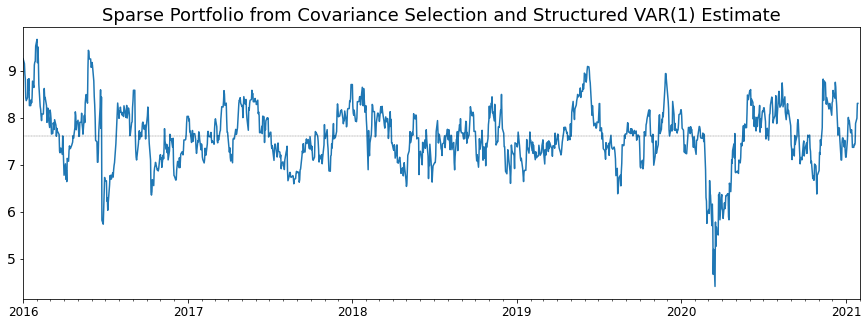

In [38]:
plot_portf(sparse_portf1, "Sparse Portfolio from Covariance Selection and Structured VAR(1) Estimate")

Half-life is around 9 days, which gives enough number of trades. Figure 1 also shows that the portfolio is decently mean-reverting. 

### Greedy Search

It has been already shown in the previous section that constructing a mean-reverting portfolio from a set of assets using Box-Tiao canonical decomposition is equivalent to solving the generalized eigenvalue problem,

$$
\det (\lambda \Gamma_0 - A^T \Gamma_0 A) = 0
$$

and retrieve the eigenvector corresponding to the smallest eigenvalue. This generalized eigenvalue problem can be also
written in the variational form as follows:

$$
    \lambda_{\text{min}}(A^T \Gamma_0 A, \Gamma_0) = \min_{\mathbf{x} \in \mathbb{R}^n} \frac{\mathbf{x}^T A^T \Gamma_0 A \mathbf{x}}{\mathbf{x}^T \Gamma_0 \mathbf{x}}
$$

However, once the cardinality constraint has been added, the resulting sparse generalized eigenvalue problem is equivalent to subset selection, which is an NP-hard problem. 

$$
\begin{align*}
\text{minimize } & \frac{\mathbf{x}^T A^T \Gamma_0 A \mathbf{x}}{\mathbf{x}^T \Gamma_0 \mathbf{x}} \\
\text{subject to } & \lVert \mathbf{x} \rVert_0 = k \\
& \lVert \mathbf{x} \rVert_2 = 1
\end{align*}
$$

Since no polynomial time solutions are available to get the global optimal solution, greedy search is thus used to get good approximate solutions of the problem, which will have a polynomial time complexity. Greedy search builds the solution recursively, i.e. it always tries to add the asset that results in the least increase in predictability to the current "optimal" solution. Figure 2 demonstrates the working process of the greedy algorithm with a toy example.

![title](images/greedy_demo.gif)

#### Examples

The example in this section uses data of all 45 ETFs and attempts to construct a sparse mean-reverting portfolio with greedy algorithm. The sample covariance matrix and the least-square VAR(1) estimate were used here to demonstrate that the greedy algorithm can work well even without the preprocessing step with covariance selection and penalized regression.

In [42]:
# Calculate least-square VAR(1) estimate and sample covariance
full_var_est = etf_sparse_portf.least_square_VAR_fit()
full_cov_est = etf_sparse_portf.autocov(0, use_standardized=False)

# Use greedy algorithm to calculate portfolio weights
greedy_weight = etf_sparse_portf.greedy_search(8, full_var_est, full_cov_est, maximize=False)

# Pretty print the weights
greedy_weight_df = pd.DataFrame(greedy_weight.reshape(-1, 1))
greedy_weight_df.columns = ['Weight']
greedy_weight_df.index = etf_sparse_portf.assets.columns

# Print only the non-zero weights
greedy_weight_df[greedy_weight_df['Weight'] != 0]

C:\Anaconda3\envs\arbitragelab_test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


,Weight
EGPT,-0.035084
ARGT,-0.332868
EWZ,0.206248
EWW,0.504653
GXG,-0.680563
ECH,0.315425
EWY,-0.026486
TUR,-0.165515


In [39]:
# Build the portfolio and check the OU model fit
greedy_portf = etf_sparse_portf.assets @ greedy_weight

coeff, hl = etf_sparse_portf.mean_rev_coeff(greedy_weight.squeeze(), etf_sparse_portf.assets)
print("Mean-rev Coefficient: {}; half-life: {}".format(coeff, hl))

<class 'pandas.core.frame.DataFrame'>
Mean-rev Coefficient: 6.3293814183417565; half-life: 27.59718177117995


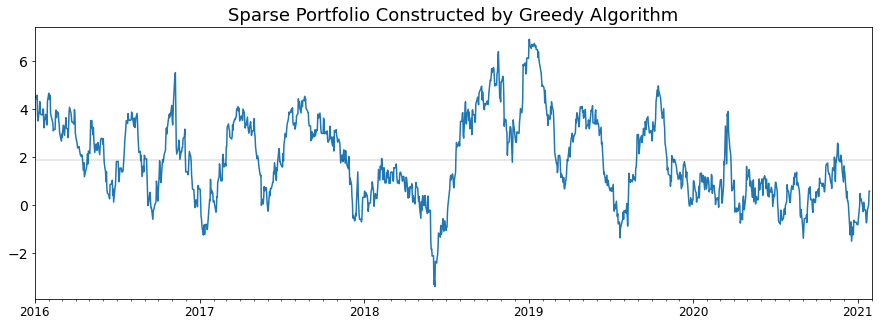

In [41]:
plot_portf(greedy_portf.squeeze(), "Sparse Portfolio Constructed by Greedy Algorithm")

The sparse portfolio built by greedy algorithm has similar volatility to the previous one, but its mean-reversion is more stable, especially during the Coronavirus crash in 2020. The OU half-life of this portfolio is longer at 27.5 days, which suggests a lower trading frequency for a possible mean-reversion strategy.

### Convex Relaxation

An alternative to greedy search is to relax the cardinality constraint and reformulate the original non-convex optimization problem

$$
\begin{align*}
\text{minimize } & \frac{\mathbf{x}^T \mathbf{A} \mathbf{x}}{\mathbf{x}^T \mathbf{B} \mathbf{x}} \\
\text{subject to } & \lVert \mathbf{x} \rVert_0 = k \\
& \lVert \mathbf{x} \rVert_2 = 1
\end{align*}    
$$

into a convex one. The concept "convex" means "when an optimal solution is found, then it is guaranteed to be the
best solution". The convex optimization problem is formed in terms of the symmetric matrix $X = \mathbf{x} \mathbf{x}^T$:

$$
\begin{align*}
\text{minimize } & \frac{\mathbf{Tr} (\mathbf{A} X)}{\mathbf{Tr} (\mathbf{B} X)} \\
\text{subject to } & \mathbf{1}^T \lvert X \rvert \mathbf{1} \leq k \\
& \mathbf{Tr} (X) = 1 \\
& X \succeq 0
\end{align*}
$$

The objective function is the quotient of the traces of two matrices, which is only quasi-convex. Even if this quasi-convex optimization problem can be transformed into a convex optimization problem, or semidefinite programming (SDP) to be exact, with a change of variables, this formulation of SDP still suffers from a few drawbacks:

1. It has numerical stability issues;
2. It cannot proper handle volatility constraints;
3. It cannot optimize mean-reversion strength proxies other than predictability.

Therefore, this module followed the regularizer form of the SDP proposed by Cuturi (2015) to mitigate these drawbacks.

The predictability optimization SDP is as follows:

$$
\begin{align*}
\text{minimize } & \mathbf{Tr} (\gamma_1 \gamma_0^{-1} \gamma_1^T X) + \rho \lVert X \rVert_1 \\
\text{subject to } & \mathbf{Tr} (\gamma_0 X) \geq V \\
& \mathbf{Tr} (X) = 1 \\
& X \succeq 0
\end{align*}
$$

The portmanteau statistic optimization SDP is as follows:
$$
\begin{align*}
\text{minimize } & \sum_{i=1}^p \mathbf{Tr} (\gamma_i X)^2 + \rho \lVert X \rVert_1 \\
\text{subject to } & \mathbf{Tr} (\gamma_0 X) \geq V \\
& \mathbf{Tr} (X) = 1 \\
& X \succeq 0
\end{align*}
$$

The crossing statistic optimization SDP is as follows:
$$
\begin{align*}
\text{minimize } & \mathbf{Tr}(\gamma_1 X) + \mu \sum_{i=2}^p \mathbf{Tr} (\gamma_i X)^2 + \rho \lVert X \rVert_1 \\
\text{subject to } & \mathbf{Tr} (\gamma_0 X) \geq V \\
& \mathbf{Tr} (X) = 1 \\
& X \succeq 0
\end{align*}
$$

where $\rho>0$ is the $\ell_1$-regularization parameter, $\mu>0$ is a specific regularization parameter
for crossing statistic optimization, and $V > 0$ is the portfolio variance lower threshold.

In some restricted cases, the convex relaxation are tight, which means the optimal solution of the SDP is exactly the
optimal solution to the original non-convex problem. However, in most cases this correspondence is not guaranteed and the
optimal solution of these SDPs has to be deflated into a rank one matrix $xx^T$ where $x$ can be considered
as a good candidate for portfolio weights with the designated cardinality $k$. This module uses Truncated Power
method (Yuan and Zhang, 2013) as the deflation method to retrieve the leading sparse vector of the optimal solution
$X^*$ that has $k$ non-zero elements.

<div class="alert alert-block alert-info">
<b>Tip:</b> Covariance selection determines the size of the clusters. When fitting the graphical LASSO model, apply a larger regularizer parameter to make the covariance matrix as sparse as possible such that smaller clusters are obtained. </div> 

#### Examples: Predictability

The examples in the following section also uses data of all 45 ETFs to demonstrate the effectiveness of the convex relaxation framework.

In [44]:
# Solve the predictability SDP
sdp_pred_vol_result = etf_sparse_portf.sdp_predictability_vol(rho=0.001, variance=5, 
                                                              max_iter=5000, use_standardized=False,
                                                              verbose=False)

# Deflate the optimization result into a weight vector
sdp_pred_vol_weights = etf_sparse_portf.sparse_eigen_deflate(sdp_pred_vol_result, 8, verbose=False)

<div class="alert alert-block alert-warning">
    
<b>Note:</b> Running `sparse_eigen_deflate` method after getting the SDP result is a required step. In most cases, the SDP result is a full-rank matrix rather than a rank-one matrix, so it cannot be translated into a feasible portfolio weight vector with the desired cardinality unless `sparse_eigen_deflate` has been run immediately afterwards.
    
</div>

In [45]:
# Pretty print the weights
sdp_pred_vol_weight_df = pd.DataFrame(sdp_pred_vol_weights.reshape(-1, 1))
sdp_pred_vol_weight_df.columns = ['Weight']
sdp_pred_vol_weight_df.index = etf_sparse_portf.assets.columns

# Print only the non-zero weights
sdp_pred_vol_weight_df[sdp_pred_vol_weight_df['Weight'] != 0]

,Weight
EGPT,0.113252
ENZL,-0.149504
EZA,-0.741930
GXC,-0.092458
EPU,0.084069
ARGT,0.523672
EIS,-0.047370
ECH,0.349672


In [47]:
# Build the portfolio and check the OU model fit
sdp_pred_vol_portf = etf_sparse_portf.assets @ sdp_pred_vol_weights

coeff, hl = etf_sparse_portf.mean_rev_coeff(sdp_pred_vol_weights.squeeze(), etf_sparse_portf.assets)
print("Mean-rev Coefficient: {}; half-life: {}".format(coeff, hl))

Mean-rev Coefficient: 10.08116784431103; half-life: 17.326672087865013


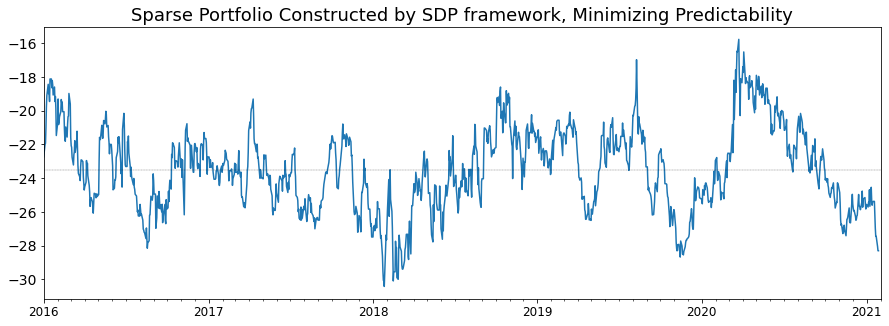

In [48]:
plot_portf(sdp_pred_vol_portf.squeeze(), "Sparse Portfolio Constructed by SDP framework, Minimizing Predictability")

#### Examples: Portmanteau

In [51]:
# Solve the portmanteau SDP
sdp_portmanteau_vol_result = etf_sparse_portf.sdp_portmanteau_vol(rho=0.001, variance=5, nlags=3,
                                                                  max_iter=10000, use_standardized=False,
                                                                  verbose=False)

# Deflate the optimization result into a weight vector
sdp_portmanteau_vol_weights = etf_sparse_portf.sparse_eigen_deflate(sdp_portmanteau_vol_result, 8, verbose=False)

<div class="alert alert-block alert-info">
    
<b>Tip:</b> Use `verbose=True` to output `cvxpy` solver info to confirm if an accurate solution has been obtained. 

</div> 

In [52]:
# Pretty print the weights
sdp_portmanteau_vol_weight_df = pd.DataFrame(sdp_portmanteau_vol_weights.reshape(-1, 1))
sdp_portmanteau_vol_weight_df.columns = ['Weight']
sdp_portmanteau_vol_weight_df.index = etf_sparse_portf.assets.columns

# Print only the non-zero weights
sdp_portmanteau_vol_weight_df[sdp_portmanteau_vol_weight_df['Weight'] != 0]

,Weight
EZA,0.356750
EDEN,-0.418944
GXC,0.477618
EPU,-0.317568
EIRL,-0.243837
ARGT,-0.301954
EIS,0.293481
EWW,0.362605


In [53]:
# Build the portfolio and check the OU model fit
sdp_portmanteau_vol_portf = etf_sparse_portf.assets @ sdp_portmanteau_vol_weights

coeff, hl = etf_sparse_portf.mean_rev_coeff(sdp_portmanteau_vol_weights.squeeze(), etf_sparse_portf.assets)
print("Mean-rev Coefficient: {}; half-life: {}".format(coeff, hl))

Mean-rev Coefficient: 4.742587399571393; half-life: 36.83075814625833


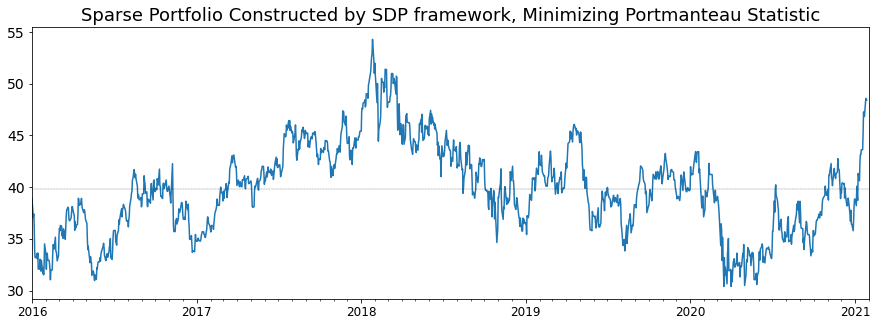

In [55]:
plot_portf(sdp_portmanteau_vol_portf.squeeze(), 
           "Sparse Portfolio Constructed by SDP framework, Minimizing Portmanteau Statistic")

#### Examples: Crossing Statistic

In [79]:
# Solve the crossing statistic SDP
sdp_crossing_vol_result = etf_sparse_portf.sdp_crossing_vol(rho=0.002, mu=0.1, variance=5, nlags=4,
                                                            max_iter=10000, use_standardized=False,
                                                            verbose=False)

# Deflate the optimization result into a weight vector
sdp_crossing_vol_weights = etf_sparse_portf.sparse_eigen_deflate(sdp_crossing_vol_result, 8, verbose=False)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 13326
eps = 1.00e-04, alpha = 1.50, max_iters = 10000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 3063, constraints m = 5096
Cones:	primal zero / dual free vars: 1
	linear vars: 4051
	soc vars: 9, soc blks: 3
	sd vars: 1035, sd blks: 1
Setup time: 8.97e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.83e+00  3.44e+01  9.92e-01 -4.79e+01  7.92e+01  0.00e+00  6.87e-03 
   100| 1.55e-02  7.67e-03  1.34e-04  5.25e+01  5.25e+01  1.16e-15  9.83e-02 
   200| 1.60e-03  1.15e-02  2.90e-

  9500| 5.34e-02  3.25e-01  2.02e-02  5.39e+01  5.18e+01  2.08e-15  7.95e+00 
  9600| 1.60e-02  7.10e-02  1.58e-03  5.19e+01  5.21e+01  3.75e-15  8.03e+00 
  9700| 4.15e-02  5.40e-01  1.88e-03  5.36e+01  5.38e+01  1.80e-15  8.11e+00 
  9800| 8.40e-03  2.02e-01  5.41e-04  5.19e+01  5.19e+01  1.63e-15  8.19e+00 
  9900| 7.74e-03  3.67e-02  2.94e-04  5.24e+01  5.24e+01  3.20e-15  8.28e+00 
 10000| 2.75e-02  4.11e-02  2.27e-03  5.18e+01  5.21e+01  6.74e-16  8.38e+00 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate, returning best found solution.
Timing: Solve time: 8.38e+00s
	Lin-sys: nnz in L factor: 31449, avg solve time: 6.69e-05s
	Cones: avg projection time: 4.08e-04s
	Acceleration: avg step time: 2.72e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.3033e-09, dist(y, K*) = 1.0020e-09, s'y/|s||y| = 3.2469e-13
primal res: |Ax + s

In [80]:
# Pretty print the weights
sdp_crossing_vol_weight_df = pd.DataFrame(sdp_crossing_vol_weights.reshape(-1, 1))
sdp_crossing_vol_weight_df.columns = ['Weight']
sdp_crossing_vol_weight_df.index = etf_sparse_portf.assets.columns

# Print only the non-zero weights
sdp_crossing_vol_weight_df[sdp_crossing_vol_weight_df['Weight'] != 0]

,Weight
EZA,0.333880
EDEN,-0.431632
GXC,0.506088
EPU,-0.296316
EIRL,-0.252190
ARGT,-0.294151
EIS,0.279118
EWW,0.360913


In [81]:
# Build the portfolio and check the OU model fit
sdp_crossing_vol_portf = etf_sparse_portf.assets @ sdp_crossing_vol_weights

coeff, hl = etf_sparse_portf.mean_rev_coeff(sdp_crossing_vol_weights.squeeze(), etf_sparse_portf.assets)
print("Mean-rev Coefficient: {}; half-life: {}".format(coeff, hl))

Mean-rev Coefficient: 4.522409184625563; half-life: 38.623902077442914


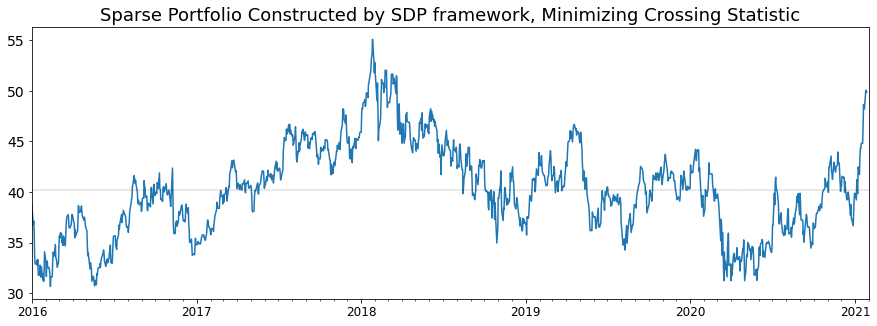

In [82]:
plot_portf(sdp_crossing_vol_portf.squeeze(), 
           "Sparse Portfolio Constructed by SDP framework, Minimizing Crossing Statistic")

Minimizing portmanteau statistic and crossing statistic yielded similar mean-reverting portfolios, both of which have a slightly longer OU half-life than the greedy algorithm result. On the other hand, minimizing predictability has generated a noisier portfolio with a shorter OU half-life.

## Discussion

The notebook has demonstrated how to use ArbitrageLab to construct sparse mean-reverting portfolios using covariance selection techniques and structured VAR(1) estimate, greedy algorithm, and convex relaxation framework with SDP. The module allows considerable flexibility and efficiency for sparse mean-reverting portfolio construction.

Among the three approaches, greedy algorithm is the most robust due to its simplicity and the stableness of the portfolio it generates. As shown in the example, the portfolio generated by greedy algorithm was able to stand the test of a market crash. Moreover, greedy algorithm runs fast. Therefore, it is the top choice if given a completely new dataset.

Convex relaxation framework has shown greater flexibility compared to the other two approaches as it allows addition of other constraints. The examples here has shown that a volatility lower bound could be added such that meaningful statistical arbitrage opportunities are available as the deviation from portfolio mean is greater. However, the mean-reversion strengths of the portfolios are slightly weaker than the one generated by the greedy algorithm, which is likely because the convex relaxation is not tight.

Covariance selection and structured VAR(1) estimate approach can narrow down the investing universe effectively. The examples have shown that the 45 international equity ETFs have been readily clustered into a 14-asset and an 8-asset subset from which a sparse mean-reverting portfolio can be constructed using Box-Tiao canonical decomposition. Note that this approach can be used in conjunction with the greedy algorithm and convex relaxation approach. For example, greedy algorithm can be directly applied to the aforementioned 14-asset subset.

## Conclusion

This research notebook has discussed in detail the theoretical background for solving sparse mean-reversion portfolio selection problem and how ArbitrageLab can help build them in three different approaches.

### Key Takeaways

* Greedy algorithm is the most robust approach among the three. It is recommended to try greedy algorithm first when given a new dataset.
* Convex relaxation is the most flexible approach among the three. Extra constraints can be added, for example, a volatility lower threshold. However, the quality of the solution may be compromised due to an extra deflation step to yield the sparse weight vector.
* Covariance selection and structured VAR(1) estimate is more of a preprocessing step among the three. This approach can efficiently narrow down the investing universe. Box-Tiao canonical decomposition, greedy algorithm, and convex relaxation can be all applied afterwards on the resulting asset subsets.
* This module helps select which assets to trade and allocate the capital for each selected asset. It does **NOT** help decide the mean-reversion trading strategy. The users can choose whichever strategies they may find suitable for the highly mean-reverting portfolio.